## Project Goals
The goal of this project is to assess features of real estate to find meaningful clusters for use in predicting logerror.


## Project Description
With low interest rates and a strong buyer's market, it is increasingly important to identify valuable real estate investment opportunities. Zillow's zestimate modeling may be improved with input from the open-source community to better predict home values and reduce logerror.

## Initial Questions

1. Does a cluster created from the number of bedrooms and bathrooms and the calculated sqft correlate with logerror?
2. Does a cluster created from location and age correlate with logerror?
3. Does a cluster created from tax related features correlate with logerror?
4. What features are driving logerror individually?

## Data Dictionary

| variable      | meaning       |
| ------------- |:-------------:|
|logerror|target value: log(zestimate) - log(sale price)|
|abslogerror| absolute value of the logerror|
|lm|Ordinary Least Squares (OLS) Linear Regression modeling algorithm|
|lm2|Polynomial Regression modeling algorithm |
|lars|Lasso + Lars Regression modeling algorithm|
|glm|TweedieRegressor modeling algorithm|
|df|Dataframe of raw zillow data from sql server|
|train| training dataset, a major cut from the df|
|validate| validate dataset, used to prevent overfitting|
|test| test dataset, to test the top model on unseen data|
|pearsonr| statistical test used to compare churn with various categories|
|taxvaluedollarcnt| The assessed value of the built structure on the parcel|
|calculatedfinishedsquarefeet| Calculated total finished living area of the home |
|sqft|abbreviation for square feet|
|structuretaxvaluedollarcnt| assessed value of the structure|
|landtaxvaluedollarcnt|assessed value of the land|
|taxamount|total property tax assessed for that year|
|bedroomcnt| Number of bedrooms in home |
|bathroomcnt| Number of bathrooms in home including fractional bathrooms|
|latitude/longitude| coordinates of the property|
|acres| lotsizesquarefeet / 43560|
|age| 2017 - yearbuilt|
|dollar_per_acre| landtaxvaluedollarcnt / acres|
|dollar_per_sqft| structuretaxvaluedollarcnt / calculatedfinishedsquarefeet|
|features_cluster|cluster created with features of the property|
|value_cluster|cluster created with dollar features|
|development_cluster|cluster created with location and age data|
|fips| County codes for property locations|
| County Codes||
|6037 | Los Angeles, CA|
|6059 | Orange, CA|
|6111 | Ventura, CA|

## Wrangle Zillow Data
To acquire the zillow data used, I ran a query on the zillow database from the mySQL server. I queried all columns from the zillow database by using multiple joins. I excluded any properties that did not have coordinates included or a transaction in 2017.

In [1]:
# import modules
import pandas as pd

# import visualizations
import viz

# ignore warnings to reduce clutter
import warnings
warnings.filterwarnings("ignore")

# Import wrangle module with functions to acquire, prepare, scale, and split data from SQL server's zillow database
import wrangle

# execute functions to acquire and split a df and store in train, validate, and test dataframes
train, validate, test = wrangle.split_data(wrangle.wrangle_zillow())

Cleaning the data was executed in the following steps:
- Filter data to single family homes
- Drop duplicates
- Removed outliers by setting parameters for features
- Create new columns to reduce total feature number
- Drop unnecessary columns
- Drop any remaining null values

## Our Data Landscape
- 46,763 properties assessed after data cleaning.
- Located throughout three California counties.


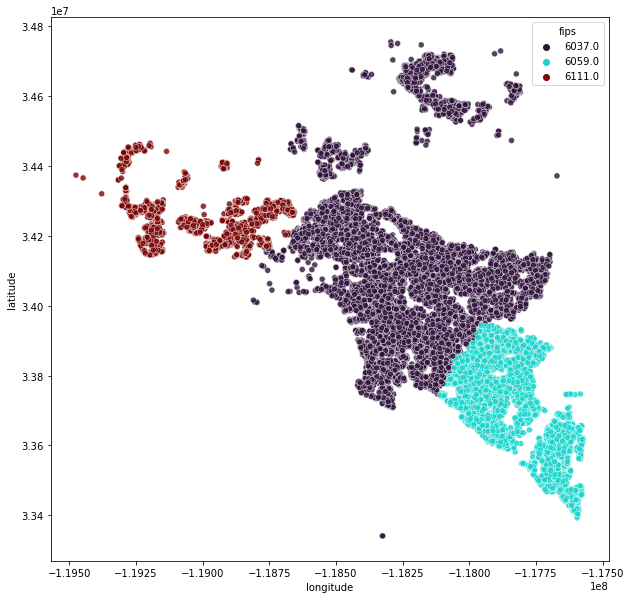

In [2]:
# visualize the number of properties in each county after data cleaning.
viz.data_map(train)

# Clusters


Clustering was created with KMeans and prior to clustering, we scaled our data using sklearn's min/max scaler

In [3]:
# scale data
scaler, train_scaled, validate_scaled, test_scaled = wrangle.min_max_scaler(train, validate, test)

Clusters were created by grouping features relative to the property, listed below
- features_cluster: bed/bath/sqft/taxvaluedollarcnt
- value_cluster: tax value features
- development_cluster: location and age features

The number of clusters (k) was found by using the elbow method, except for the development_cluster, which was was given a higher k for a better estimation of housing subdivisions.

## Cluster 1: features_cluster

In [4]:
# import clusters
from sklearn.cluster import KMeans

# define features for clustering
X_train_feature_cluster = train_scaled[['bedroomcnt','bathroomcnt','calculatedfinishedsquarefeet','taxvaluedollarcnt']]

#repeat for validate and test
X_validate_feature_cluster = validate_scaled[['bedroomcnt','bathroomcnt','calculatedfinishedsquarefeet','taxvaluedollarcnt']]
X_test_feature_cluster = test_scaled[['bedroomcnt','bathroomcnt','calculatedfinishedsquarefeet','taxvaluedollarcnt']]

# define cluster object
kmeans = KMeans(n_clusters=5, random_state = 333)
# fit cluster object to features
kmeans.fit(X_train_feature_cluster)
# use the object
train_scaled['feature_cluster'] = kmeans.predict(X_train_feature_cluster)
validate_scaled['feature_cluster'] = kmeans.predict(X_validate_feature_cluster)
test_scaled['feature_cluster'] = kmeans.predict(X_test_feature_cluster)
X_train_feature_cluster['feature_cluster'] = kmeans.predict(X_train_feature_cluster)


#define centroids
centroids = pd.DataFrame(kmeans.cluster_centers_, columns = X_train_feature_cluster.loc[:, X_train_feature_cluster.columns != 'feature_cluster'].columns)

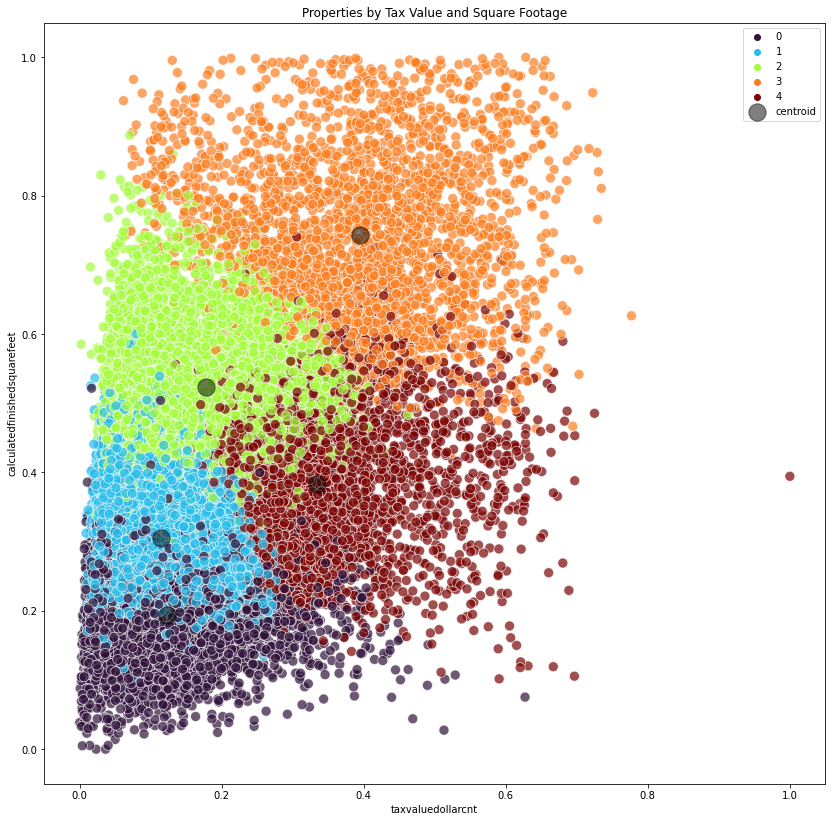

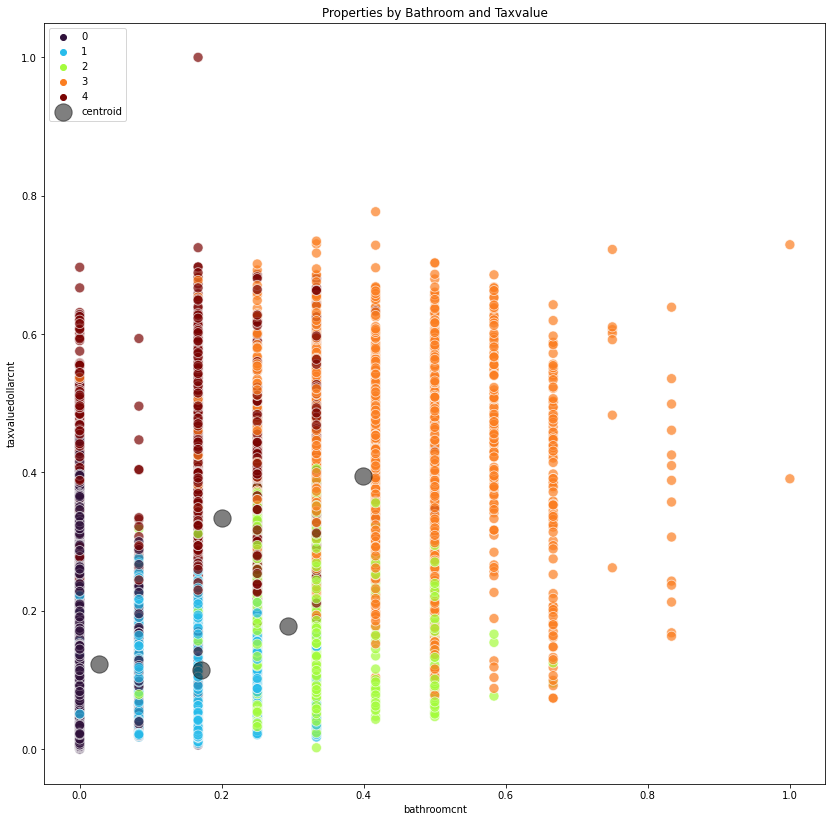

In [5]:
viz.cluster1_centroid(X_train_feature_cluster, centroids)
viz.cluster_bathroom_vs_taxvalue(X_train_feature_cluster, centroids)

This cluster is significant because it allows us to observe groups of properties based on bed/bath/sqft/taxvalue and compare them to the logerror of other groups in the cluster.

## Cluster 2: value_cluster

In [6]:
# define features for clustering
X_train_value_cluster = train_scaled[['structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount']]

#repeat for validate and test
X_validate_value_cluster = validate_scaled[['structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount']]
X_test_value_cluster = test_scaled[['structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount']]

# define cluster object
kmeans = KMeans(n_clusters=4, random_state = 333)
# fit cluster object to features
kmeans.fit(X_train_value_cluster)
# use the object
train_scaled['value_cluster'] = kmeans.predict(X_train_value_cluster)
validate_scaled['value_cluster'] = kmeans.predict(X_validate_value_cluster)
test_scaled['value_cluster'] = kmeans.predict(X_test_value_cluster)
X_train_value_cluster['value_cluster'] = kmeans.predict(X_train_value_cluster)

# define centroids
centroids = pd.DataFrame(kmeans.cluster_centers_, columns = X_train_value_cluster.loc[:, X_train_value_cluster.columns != 'value_cluster'].columns)

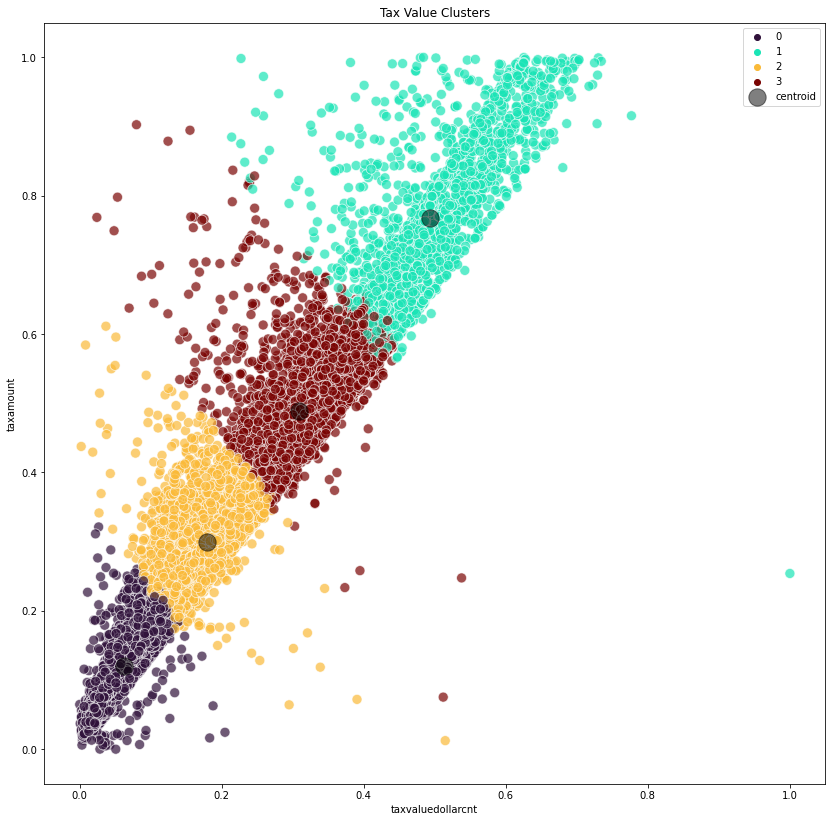

In [7]:
viz.cluster2_with_centroid(X_train_value_cluster, centroids)

This cluster is significant because it creates four distinguishable clusters from low tax values to higher tax values.

## Cluster 3: development_cluster

In [8]:
# define features for clustering
X_train_development_cluster = train[['latitude','longitude','age']]
X_validate_development_cluster = validate[['latitude','longitude','age']]
X_test_development_cluster = test[['latitude','longitude','age']]

# define cluster object
kmeans = KMeans(n_clusters=10, random_state = 333)
# fit cluster object to features
kmeans.fit(X_train_development_cluster)
# use the object
train_scaled['development_cluster'] = kmeans.predict(X_train_development_cluster)
validate_scaled['development_cluster'] = kmeans.predict(X_validate_development_cluster)
test_scaled['development_cluster'] = kmeans.predict(X_test_development_cluster)
X_train_development_cluster['development_cluster'] = kmeans.predict(X_train_development_cluster)

# define centroids
centroids = pd.DataFrame(kmeans.cluster_centers_, columns = X_train_development_cluster.loc[:, X_train_development_cluster.columns != 'development_cluster'].columns)

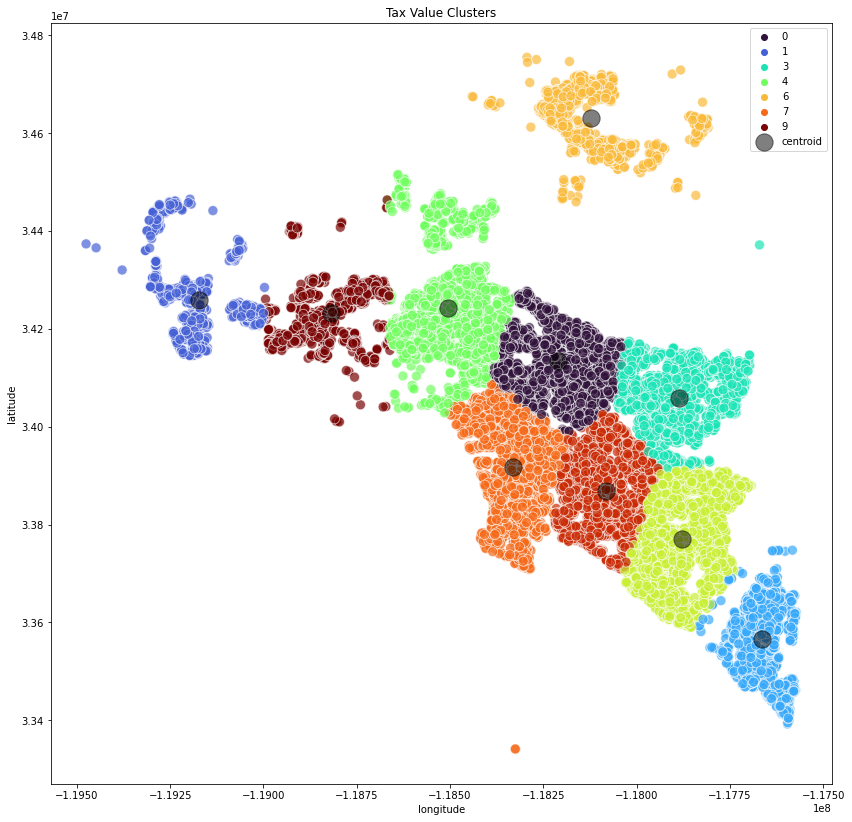

In [9]:
viz.cluster3_with_centroid(X_train_development_cluster, centroids)

This cluster is significant because it gives us an idea of subdivisions of the counties.

## Exploratory analysis: What correlates with log error?

In [10]:
# import statistics module and establish alpha
from scipy import stats
alpha = 0.5

### 1. Is logerror different between clusters based on house features?
- Run anova test

$H_{0}$: Means of the logerror between clusters are equal

$H_{a}$ Means of the logerror between clusters are not equal

In [11]:
f, p = stats.f_oneway(train_scaled[train_scaled.feature_cluster == 0].logerror,
                     train_scaled[train_scaled.feature_cluster == 1].logerror,
                     train_scaled[train_scaled.feature_cluster == 2].logerror,
                     train_scaled[train_scaled.feature_cluster == 3].logerror)

if p < alpha:
    print("The mean logerror of the clusters are not equal.")
else:
    print("The mean logerror of the clusters are equal.")

The mean logerror of the clusters are not equal.


#### The means are not equal so we check for correlation
- pearsonr test

$H_{0}$: There is no correlation between feature clusters and logerror

$H_{a}$ There is a correlation between feature clusters and logerror

In [12]:
x = train_scaled.feature_cluster
y = train_scaled.logerror

corr, p = stats.pearsonr(x, y)

if p < alpha:
    print('There is a correlation between feature clusters and logerror')
else:
    print('There is no correlation between feature clusters and logerror')

There is a correlation between feature clusters and logerror


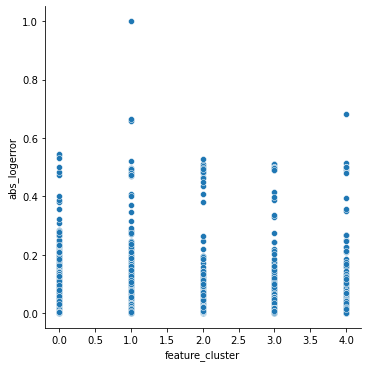

In [13]:
viz.feature_cluster_stats(train_scaled)

#### We can use this cluster for modeling.

### 2. Is logerror different between clusters based on value and is there a correlation between the clusters and logerror?

- Run anova test

$H_{0}$: Means of the logerror between clusters are equal

$H_{a}$ Means of the logerror between clusters are not equal

In [14]:
f, p = stats.f_oneway(train_scaled[train_scaled.value_cluster == 0].logerror,
                     train_scaled[train_scaled.value_cluster == 1].logerror,
                     train_scaled[train_scaled.value_cluster == 2].logerror,
                     train_scaled[train_scaled.value_cluster == 3].logerror)

if p < alpha:
    print("The mean logerror of the clusters are not equal.")
else:
    print("The mean logerror of the clusters are equal.")

The mean logerror of the clusters are not equal.


#### The means are different, is there a correlation?

- pearsonr test

$H_{0}$: There is no correlation between feature clusters and logerror

$H_{a}$ There is a correlation between feature clusters and logerror

In [15]:
x = train_scaled.value_cluster
y = train_scaled.logerror

corr, p = stats.pearsonr(x, y)

if p < alpha:
    print('There is a correlation between value clusters and logerror')
else:
    print('There is no correlation between value clusters and logerror')

There is a correlation between value clusters and logerror


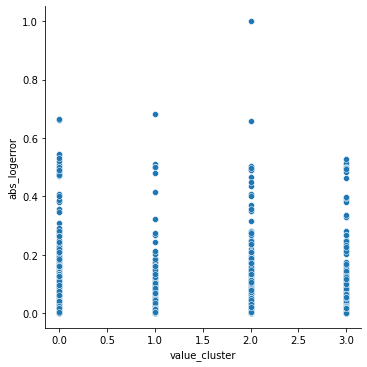

In [16]:
viz.value_cluster_stats(train_scaled)

#### We can use this cluster for modeling

### 3. Is logerror different between clusters based on location and age and is there a correlation between the clusters and logerror?

- Run anova test

$H_{0}$: Means of the logerror between clusters are equal

$H_{a}$ Means of the logerror between clusters are not equal



In [17]:
f, p = stats.f_oneway(train_scaled[train_scaled.development_cluster == 0].logerror,
                     train_scaled[train_scaled.development_cluster == 1].logerror,
                     train_scaled[train_scaled.development_cluster == 2].logerror,
                     train_scaled[train_scaled.development_cluster == 3].logerror)

if p < alpha:
    print("The mean logerror of the clusters are not equal.")
else:
    print("The mean logerror of the clusters are equal.")

The mean logerror of the clusters are not equal.


#### The means are different, is there a correlation?

- pearsonr test

$H_{0}$: There is no correlation between feature clusters and logerror

$H_{a}$ There is a correlation between feature clusters and logerror

In [18]:
x = train_scaled.development_cluster
y = train_scaled.logerror

corr, p = stats.pearsonr(x, y)

if p < alpha:
    print('There is a correlation between development clusters and logerror')
else:
    print('There is no correlation between development clusters and logerror')

There is no correlation between development clusters and logerror


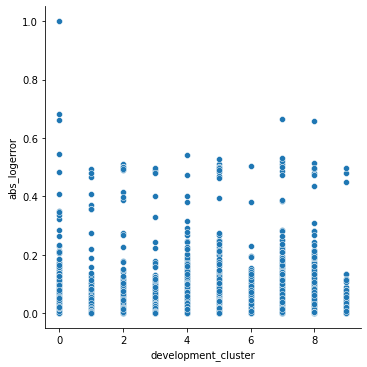

In [19]:
viz.development_cluster_stats(train_scaled)

#### We will not be using this cluster for modeling

### 4. Use SelectKBest to learn which features have the strongest relationship with logerror, including our models.

In [20]:
from sklearn.feature_selection import SelectKBest, f_regression

# Define our X_train, minus some of the features we've included in our clusters and our target
X_train_scaled = train_scaled.drop(columns=['abs_logerror','logerror','latitude','longitude','bedroomcnt','bathroomcnt'])
y_train = train_scaled.logerror


# our selecter is an f_regression stats test and retrieving 10 features
f_selector = SelectKBest(f_regression, k=10)

# find the top 5 features correlated with our target
f_selector.fit(X_train_scaled, y_train)

# boolean mask of whether the column was selected or not. 
feature_mask = f_selector.get_support()

# get list of top K features. 
f_feature = X_train_scaled.iloc[:,feature_mask].columns.tolist()

f_feature

['calculatedfinishedsquarefeet',
 'regionidcounty',
 'regionidzip',
 'structuretaxvaluedollarcnt',
 'taxvaluedollarcnt',
 'landtaxvaluedollarcnt',
 'taxamount',
 'dollar_per_sqft',
 'dollar_per_acre',
 'value_cluster']

We will model with SelectKBest's recommendation in addition to our selected clusters.

Statistical tests for the SelectKBest's features were performed in our exploration notebook, available for reference

## So what affects logerror?
Through statistical tests we determined the development cluster is not useful and that will not be included in modeling. Our other clusters and the features selected by SelectKBest are each correlated with logerror and we'll use these moving forward in modeling.

## Modeling: Predicting logerror
Logerror is a continuous target variable. We have created models using linear regression algorithms. The models were be fit on a training dataset and then validated with a separate dataset to ensure there is no overfitting. The primary measure of model performance used was RMSE.

In [21]:
#import linear regression modules
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

#import evaluation metrics
from sklearn.metrics import mean_squared_error, explained_variance_score

### Create X and y for modeling purposes.

In [22]:
# define features to use in modeling
features = ['taxvaluedollarcnt','landtaxvaluedollarcnt','taxamount','dollar_per_sqft','dollar_per_acre','feature_cluster','value_cluster','fips','age']

# X_train with selected features and clusters
X_train = train_scaled[features]
# Series containing target
y_train = train.logerror

# X and y validate are created
X_validate = validate_scaled[features]
y_validate = validate.logerror

# X and y test are created
X_test = test_scaled[features]
y_test = test.logerror


## Baseline
We created a baseline model using the mean logerror and evaluated it against the actual logerror, establishing a goal of beating this RMSE in our models.

In [23]:
# Create dataframes of the target for modeling purposes
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

# predict mean
pred_mean = y_train.logerror.mean()
y_train['baseline_pred_mean'] = pred_mean
y_validate['baseline_pred_mean'] = pred_mean

# RMSE of mean
rmse_train = mean_squared_error(y_train.logerror, y_train.baseline_pred_mean)**(1/2)
print("Train/In-Sample RMSE: ", rmse_train)

# validate rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.baseline_pred_mean)**(1/2)
print("Validate/Out-of-Sample RMSE: ", rmse_validate)

Train/In-Sample RMSE:  0.1695546484055886
Validate/Out-of-Sample RMSE:  0.1594845483479586


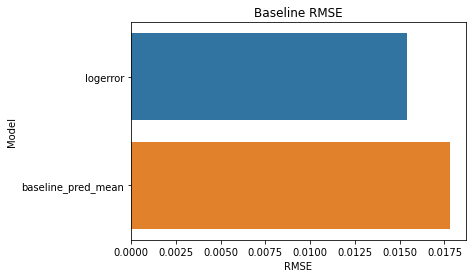

In [24]:
viz.RMSE_baseline_model(y_validate)

## Four Models
The models we created were Ordinary Least Squares, TweedieRegressor, Polynomial, and LassoLars. The best performing model was the OLS model. 

## OLS Model

In [25]:
# Create model
lm = LinearRegression(normalize=True)

# fit the model to training data.
lm.fit(X_train, y_train.logerror)

# predict train
y_train['logerror_pred_lm'] = lm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lm)**(1/2)

print("Training/In-Sample RMSE: ", rmse_train)

Training/In-Sample RMSE:  0.16923050164099987


### Evaluate on Validate

In [26]:
# predict validate
y_validate['logerror_pred_lm'] = lm.predict(X_validate)

# evaluate rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lm)**(1/2)

print("Validation/Out-of-Sample RMSE:", rmse_validate)

Validation/Out-of-Sample RMSE: 0.15917290222422487


## GLM Model

In [27]:
# create the model object
glm = TweedieRegressor(power = 0, alpha=0.5)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train, y_train.logerror)

# predict train
y_train['logerror_pred_glm'] = glm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_glm)**(1/2)

print("RMSE for GLM using Tweedie, power=0 & alpha=0\nTraining/In-Sample: ", rmse_train) 

RMSE for GLM using Tweedie, power=0 & alpha=0
Training/In-Sample:  0.16948538783486114


### Evaluate on Validate

In [28]:
# predict validate
y_validate['logerror_pred_glm'] = glm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_glm)**(1/2)

print("Validation/Out-of-Sample: ", rmse_validate)

Validation/Out-of-Sample:  0.15942857716464665


## Polynomial Model

In [29]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate & X_test
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 = pf.transform(X_test)

# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data.
lm2.fit(X_train_degree2, y_train.logerror)

# predict train
y_train['logerror_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=3\nTraining/In-Sample: ", rmse_train)

RMSE for Polynomial Model, degrees=3
Training/In-Sample:  0.1688835815352781


### Evaluate on Validate

In [30]:
# predict validate
y_validate['logerror_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lm2)**(1/2)

print('Validation/Out-of-Sample:', rmse_validate)

Validation/Out-of-Sample: 0.15936339599028418


## LassoLars Model

In [31]:
# create the model object
lars = LassoLars(alpha=10)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train, y_train.logerror)

# predict train
y_train['logerror_pred_lars'] = lars.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lars)**(1/2)


print("RMSE for LassoLars Model, alpha = 10 \nTraining/In-Sample: ", rmse_train)

RMSE for LassoLars Model, alpha = 10 
Training/In-Sample:  0.1695546484055886


### Evaluate on Validate

In [32]:
# predict validate
y_validate['logerror_pred_lars'] = lars.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lars)**(1/2)

print('Validation/Out-of-Sample: ', rmse_validate)

Validation/Out-of-Sample:  0.1594845483479586


## Validating with Visuals

Comparing all models' RMSE to our baseline model, we see that our OLS model was our top performing model.

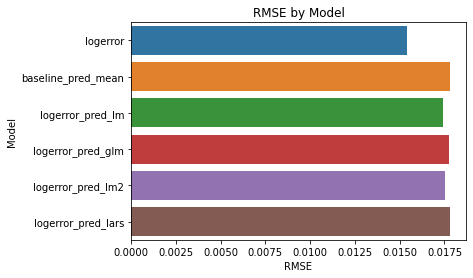

In [33]:
viz.RMSE_all_models(y_validate)

A scatter plot of each models' predictions vs the actual logerror. The ideal line for our predictions is plotted. There is a lot of overlap, but there is a slightly better fit for the OLS model, displayed in red.

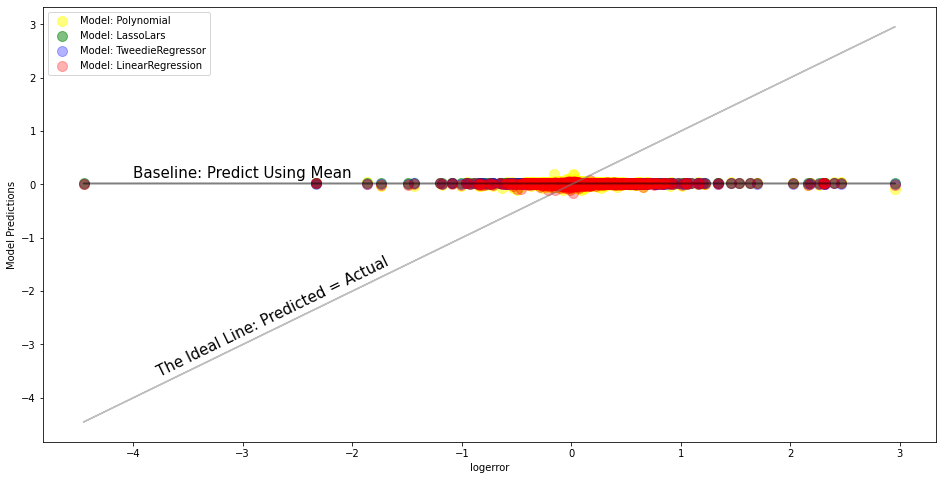

In [34]:
viz.validate_scatter(y_validate, pred_mean)

Similarly to the scatterplot, the OLS model's histogram compared to the other models' is slightly more fit to the actual values.

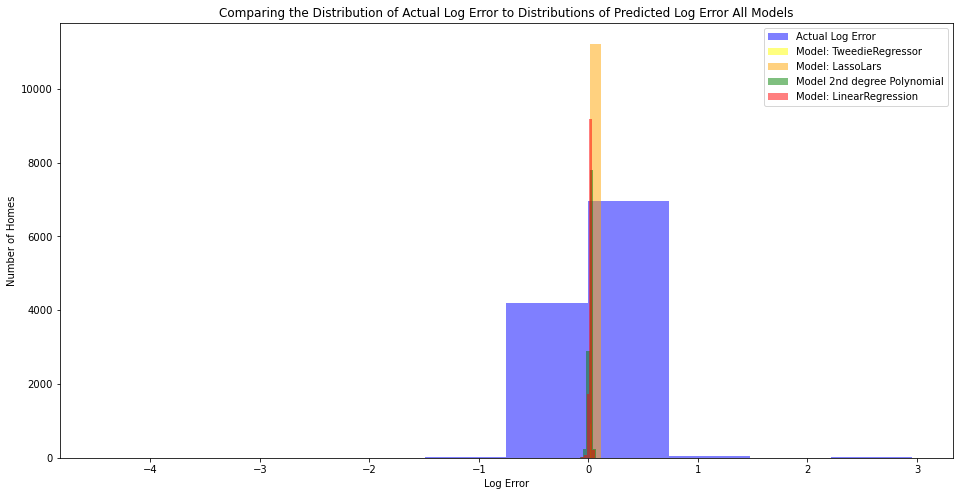

In [35]:
viz.model_compare(y_validate)

## Evaluate on Test
The OLS model performed the best of the four models and was evaluated on the test dataset.

In [36]:
y_test = pd.DataFrame(y_test)

# predict on test
y_test['logerror_pred_lm'] = lm.predict(X_test)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.logerror, y_test.logerror_pred_lm)**(1/2)

print("Out-of-Sample Performance RMSE: ", rmse_test)

Out-of-Sample Performance RMSE:  0.17132528016024579


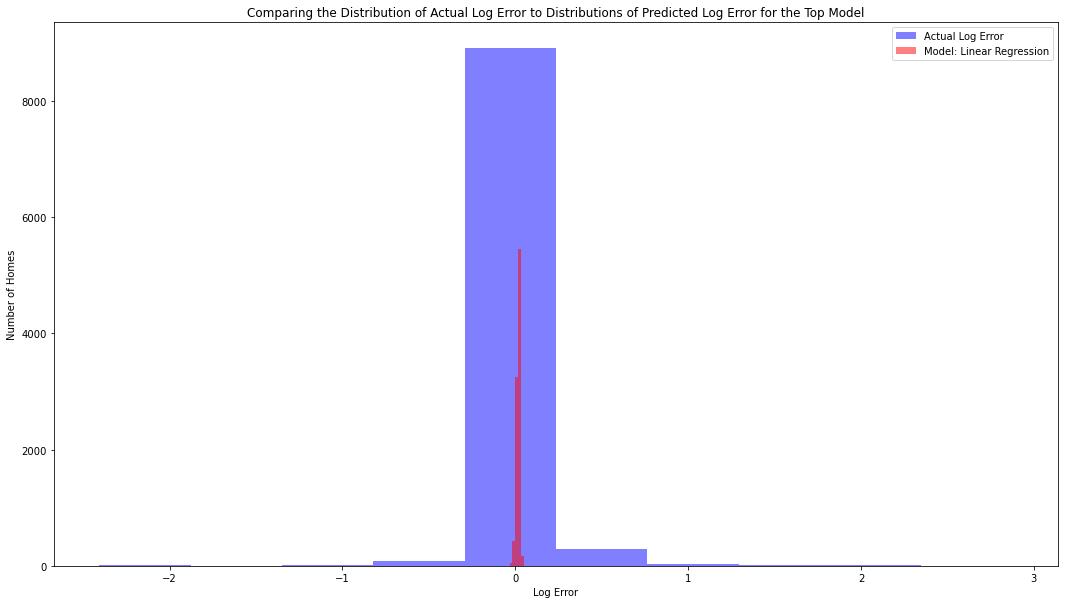

In [37]:
viz.best_model_vs_logerror(y_test)

## Conclusion
### Summary
#### What features matter?
Through statistical testing of the features we analyzed and clusters we've created, in combination with verification through SelectKBest, we've decided that the sqft, location, and features of the properties are drivers of logerror.

#### Modeling
The data was modeled through four different linear regression algorithms, with the OLS model being the top performer. The model performed better in the validation dataset than in training, beating the baseline in validation. Our model did not beat baseline evaluating with our test dataset.

### Recommendations and Next Steps
Our recommendation is to explore further combinations of features in clustering and how they relate to logerror, with the goal of creating more meaningful features from clusters to implement in our modeling.